In [1]:
import tensorflow as tf

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np

import pandas as pd

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:

# 데이터 입력
df = pd.read_csv('../dataset/winequality-red.csv')

# 데이터 분류
dataset = df.copy()
label=dataset.pop('quality')


In [4]:

# 전체 데이터에서 학습 데이터와 테스트 데이터로 구분
X_train1, X_test, Y_train1, Y_test = train_test_split(dataset, label, test_size=0.2,shuffle=True)  ## shuffle=True로 하면 데이터를 섞어서 나눔
## 학습 셋에서 학습과 검증 데이터로 구분
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train1, Y_train1, test_size=0.2, shuffle=True)  ## shuffle=True로 하면 데이터를 섞어서 나눔


In [5]:


# train 데이터에서 normalization하기 위한 값들 추출
## train 입력 데이터 열 별로 min, max, mean, std 구하기.
dataset_stats = X_train.describe()
dataset_stats = dataset_stats.transpose()

## data normalization
def standard_norm(x):
  return (x - dataset_stats['mean']) / dataset_stats['std']

## train data에서 추출한 값들로 train/val/test 데이터 normalization
normed_train_data = standard_norm(X_train)
normed_val_data = standard_norm(X_valid)
normed_test_data = standard_norm(X_test)


In [6]:


# 모델의 설정
activation=tf.keras.activations.sigmoid
input_Layer = tf.keras.layers.Input(shape=(11,))
x = tf.keras.layers.Dense(70, activation=activation)(input_Layer)
x = tf.keras.layers.Dense(35, activation=activation)(x)
# Out_Layer= tf.keras.layers.Dense(9, activation='softmax')(x)
Out_Layer= tf.keras.layers.Dense(1, activation=None)(x)

model = tf.keras.models.Model(inputs=[input_Layer], outputs=[Out_Layer])
model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 11)]              0         
_________________________________________________________________
dense (Dense)                (None, 70)                840       
_________________________________________________________________
dense_1 (Dense)              (None, 35)                2485      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 36        
Total params: 3,361
Trainable params: 3,361
Non-trainable params: 0
_________________________________________________________________


In [7]:


# 모델 컴파일
loss=tf.keras.losses.mean_squared_error
optimizer = tf.keras.optimizers.Adam(lr=0.001)

## 이거 특이하네...
metrics=tf.keras.metrics.categorical_accuracy

model.compile(loss=loss,
             optimizer=optimizer,
             metrics=[metrics])

## model fit은 histoy를 반환한다. 훈련중의 발생하는 모든 정보를 담고 있는 딕셔너리.
result=model.fit(normed_train_data, Y_train, epochs=1000, batch_size=500, validation_data=(normed_val_data,Y_valid)) # validation_data=(X_valid,Y_valid)을 추가하여 학습시 검증을 해줌.
## result는 딕셔너리이므로 keys()를 통해 출력의 key(카테고리)를 확인하여 무엇을 받고 있는지 확인.
print(result.history.keys())


/home/dalu/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/1000
3/3 [==============================] - 1s 144ms/step - loss: 23.6210 - categorical_accuracy: 1.0000 - val_loss: 22.3536 - val_categorical_accuracy: 1.0000
Epoch 2/1000
3/3 [==============================] - 0s 16ms/step - loss: 21.5405 - categorical_accuracy: 1.0000 - val_loss: 20.3420 - val_categorical_accuracy: 1.0000
Epoch 3/1000
3/3 [==============================] - 0s 16ms/step - loss: 19.5648 - categorical_accuracy: 1.0000 - val_loss: 18.4428 - val_categorical_accuracy: 1.0000
Epoch 4/1000
3/3 [==============================] - 0s 16ms/step - loss: 17.7026 - categorical_accuracy: 1.0000 - val_loss: 16.6656 - val_categorical_accuracy: 1.0000
Epoch 5/1000
3/3 [==============================] - 0s 26ms/step - loss: 15.9590 - categorical_accuracy: 1.0000 - val_loss: 15.0097 - val_categorical_accuracy: 1.0000
Epoch 6/1000
3/3 [==============================] - 0s 20ms/step - loss: 14.3458 - categorical_accuracy: 1.0000 - val_loss: 13.4803 - val_categorical_accuracy: 1.00

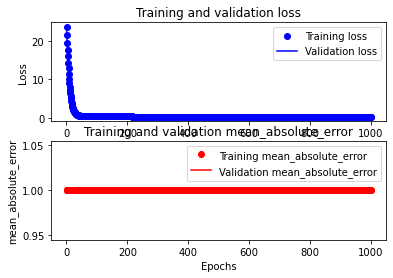

In [8]:

### result에서 loss와 val_loss의 key를 가지는 값들만 추출
loss = result.history['loss']
val_loss = result.history['val_loss']
### loss와 val_loss를 그래프화
epochs = range(1, len(loss) + 1)
plt.subplot(211)  ## 2x1 개의 그래프 중에 1번째
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

### result에서 binary_accuracy와 val_binary_accuracy key를 가지는 값들만 추출
acc = result.history['categorical_accuracy']
val_acc = result.history['val_categorical_accuracy']

### binary_accuracy와 val_binary_accuracy key를 그래프화
plt.subplot(212)  ## 2x1 개의 그래프 중에 2번째
plt.plot(epochs, acc, 'ro', label='Training mean_absolute_error')
plt.plot(epochs, val_acc, 'r', label='Validation mean_absolute_error')
plt.title('Training and validation mean_absolute_error')
plt.xlabel('Epochs')
plt.ylabel('mean_absolute_error')
plt.legend()

## 그래프 띄우기
plt.show()




In [12]:
# model.evalueate를 통해 테스트 데이터로 정확도 확인하기.
## model.evaluate(X_test, Y_test)의 리턴값은 [loss, binary_acuuracy ]  -> 위 model.compile에서 metrics=[ keras.metrics.binary_accuracy]옵션을 주어서 binary acuuracy 출력됨.
print("\n Test mean_absolute_error: %.4f" % (model.evaluate(normed_test_data, Y_test)[1]))

print(model.evaluate(normed_test_data, Y_test))


10/10 [==============================] - 0s 2ms/step - loss: 0.4358 - categorical_accuracy: 1.0000

 Test mean_absolute_error: 1.0000
10/10 [==============================] - 0s 2ms/step - loss: 0.4358 - categorical_accuracy: 1.0000
[0.43583518266677856, 1.0]


In [10]:
for i in range(10):
    input_test_data=np.expand_dims(normed_test_data.values[i][:], axis=0)
    prediction_value=model.predict(input_test_data)
    if prediction_value <=3.5:
        wine_grade='3'
    elif prediction_value >3.5 and prediction_value<=4.5:
        wine_grade = '4'
    elif prediction_value >4.5 and prediction_value<=5.5:
        wine_grade = '5'
    elif prediction_value >5.5 and prediction_value<=6.5:
        wine_grade = '6'
    elif prediction_value >6.5 and prediction_value<=7.5:
        wine_grade = '7'
    elif prediction_value > 7.5:
        wine_grade = '8'
    print("true : ", Y_test.values[i], "prediction: ", wine_grade)

true :  5 prediction:  5
true :  5 prediction:  5
true :  5 prediction:  5
true :  6 prediction:  6
true :  7 prediction:  6
true :  7 prediction:  6
true :  4 prediction:  5
true :  5 prediction:  6
true :  5 prediction:  6
true :  5 prediction:  5
